Sprintの目的
フレームワークを用いたコードを読めるようになる
フレームワークを習得し続けられるようになる
理論を知っている範囲をフレームワークで動かす

どのように学ぶか
TensorFlowのサンプルコードを元に、これまで扱ってきたデータセットを学習していきます。



2.コードリーディング

TensorFlowによって2値分類を行うサンプルコードを載せました。今回はこれをベースにして進めます。


tf.estimator などの高レベルAPIは使用していません。低レベルなところから見ていくことにします。



【問題1】スクラッチを振り返る
ここまでのスクラッチを振り返り、ディープラーニングを実装するためにはどのようなものが必要だったかを列挙してください。


（例）


重みを初期化する必要があった
エポックのループが必要だった

それらがフレームワークにおいてはどのように実装されるかを今回覚えていきましょう。


データセットの用意
以前から使用しているIrisデータセットを使用します。以下のサンプルコードではIris.csvが同じ階層にある想定です。


Iris Species


目的変数はSpeciesですが、3種類ある中から以下の2種類のみを取り出して使用します。


Iris-versicolor
Iris-virginica


【問題１回答】
・重みを初期化する必要があった

・エポックのループが必要だった

・中間層の活性化関数が必要だった

・全結合層が必要だった

・最適化手法が必要だった

・順伝播が必要だった

・逆伝播が必要だった

【問題2】スクラッチとTensorFlowの対応を考える
以下のサンプルコードを見て、先ほど列挙した「ディープラーニングを実装するために必要なもの」がTensorFlowではどう実装されているかを確認してください。


それを簡単に言葉でまとめてください。単純な一対一の対応であるとは限りません。


《サンプルコード》


＊TensorFlow バージョン 2.4 で動作を確認済みです。


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X).astype(np.float32)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.float32)[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1
# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # 重みとバイアスの宣言
        self.w1 = tf.Variable(tf.random.normal([n_input, n_hidden1]), trainable=True)
        self.w2 = tf.Variable(tf.random.normal([n_hidden1, n_hidden2]), trainable=True)
        self.w3 = tf.Variable(tf.random.normal([n_hidden2, n_classes]), trainable=True)
        self.b1 = tf.Variable(tf.random.normal([n_hidden1]), trainable=True)
        self.b2 = tf.Variable(tf.random.normal([n_hidden2]), trainable=True)
        self.b3 = tf.Variable(tf.random.normal([n_classes]), trainable=True)
    def call(self, x):
        """
        単純な3層ニューラルネットワーク
        """
        layer_1 = tf.add(tf.matmul(x, self.w1), self.b1)
        layer_1 = tf.nn.relu(layer_1)
        layer_2 = tf.add(tf.matmul(layer_1, self.w2), self.b2)
        layer_2 = tf.nn.relu(layer_2)
        layer_output = tf.matmul(layer_2, self.w3) + self.b3  # tf.addと+は等価である
        return layer_output
model = MyModel()

# # 最適化手法
optimizer = tf.keras.optimizers.Adam(learning_rate)

def train(x, y):
    logits = model(x, training=True)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(y, logits))
    return loss

def evaluate(x, y):
    logits = model(x)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(y, logits))
    # 推定結果
    correct_pred = tf.equal(tf.sign(y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
    # 指標値計算
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    return loss, accuracy

# 計算グラフの実行
for epoch in range(num_epochs):
    # エポックごとにループ
    total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
    total_loss = 0
    total_acc = 0
    for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
        # ミニバッチごとにループ
        with tf.GradientTape() as tape:
            loss = train(mini_batch_x, mini_batch_y)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        total_loss += loss
    loss = total_loss / n_samples
    val_loss, val_acc = evaluate(X_val, y_val)
    print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, val_acc : {:.3f}".format(epoch, loss, val_loss, val_acc))
_, test_acc = evaluate(X_test, y_test)
print("test_acc : {:.3f}".format(test_acc))



【問題２回答】

・重みを初期化する必要があった

⇨SimpleInitializerというクラスで、初期化してたが、
tf.Variableを使用して、重みとバイアスを初期化してる

・エポックのループが必要だった

⇨テンソルフローでも使用してるが、
DNNでは、順伝播と逆伝播使用してたが、
それがない。（AとZと　dAとdZの計算がない）
⇨fit内でエポック使用してたが、fitがない

・中間層の活性化関数が必要だった

⇨tf.nn.reluになった

・全結合層が必要だった

⇨⇨全結合層FCクラス使用してない

・最適化手法が必要だった

tf.keras.optimizers.を使用している

・全結合層に書いた順伝播が必要だった

⇨使用してない

・全結合層に書いた逆伝播が必要だった

⇨使用してない


・ディープラーニングでも一般的に使われる最適化アルゴリズムに「最急降下法」があります。本来であればアルゴリズムの処理をスクラッチでコーディングしなくてはいけません。しかし、TensorFlowを使うことで、容易に最急降下法の処理を組み込むことが可能になります。

3.他のデータセットへの適用

これまで扱ってきた小さなデータセットが他にもいくつかあります。上記サンプルコードを書き換え、これらに対して学習・推定を行うニューラルネットワークを作成してください。


Iris（3種類すべての目的変数を使用）
House Prices

どのデータセットも train, val, test の3種類に分けて使用してください。




【問題3】3種類すべての目的変数を使用したIrisのモデルを作成
Irisデータセットのtrain.csvの中で、目的変数Speciesに含まれる3種類すべてを分類できるモデルを作成してください。


Iris Species


2クラスの分類と3クラス以上の分類の違いを考慮してください。それがTensorFlowでどのように書き換えられるかを公式ドキュメントなどを参考に調べてください。


《ヒント》


以下の2箇所は2クラス分類特有の処理です。


1
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))

1
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))

メソッドは以下のように公式ドキュメントを確認してください。


tf.nn.sigmoid_cross_entropy_with_logits  |  TensorFlow


tf.math.sign  |  TensorFlow


＊tf.signとtf.math.signは同じ働きをします。

In [11]:

#scikit-learnからデータの取り出し
from sklearn import datasets
iris = datasets.load_iris()
 
#アヤメの分類に使用するデータの確認
print(iris.DESCR)
iris.data
iris.target
 
#アヤメの分類の学習
from sklearn.model_selection import train_test_split as split
x_train, x_test, y_train, y_test = split(iris.data,iris.target,train_size=0.8,test_size=0.2)
import tensorflow as tf
import keras
from keras.layers import Dense,Activation
 
#ニュートラルネットワークで使用するモデル作成
model = keras.models.Sequential()
model.add(Dense(units=32,input_dim=4))
model.add(Activation('relu'))
model.add(Dense(units=3))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
 
#教師あり学習の実行
model.fit(x_train,y_train,epochs=100)
 
#評価の実行
score = model.evaluate(x_test,y_test,batch_size = 1)
print(score[1])
 
#1つのデータに対する評価の実行方法
import numpy as np
x = np.array([[5.1,3.5,1.4,0.2]])
r = model.predict(x)
print(r)
r.argmax()

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

0

【問題4】House Pricesのモデルを作成
回帰問題のデータセットであるHouse Pricesを使用したモデルを作成してください。


House Prices: Advanced Regression Techniques


この中のtrain.csvをダウンロードし、目的変数としてSalePrice、説明変数として、GrLivAreaとYearBuiltを使ってください。説明変数はさらに増やしても構いません。


分類問題と回帰問題の違いを考慮してください。

In [23]:

# #House Pricesのモデルを作成
# import pandas as pd
# # import os
# # os.listdir()
# # print(os.listdir())


# #House Pricesのモデルの学習
# from sklearn.model_selection import train_test_split as split
# import tensorflow as tf
# import keras
# from keras.layers import Dense,Activation
# from sklearn.preprocessing import StandardScaler

# df = pd.read_csv('/content/drive/MyDrive/DIC/train.csv')
# # print(df)
# x=df.loc[:,['GrLivArea','YearBuilt']]
# # print(type(x))
# # print(x)

# target = df.loc[:, ['SalePrice']]
# # print(target[:])
# # print(type(target))

# X=x
# #print(df.sample(n=3))
# X = X.sample(n=32)#サンプル数を5００へ絞り込み
# # X=X.values

# # X=X.tolist()
# # scaler = StandardScaler()
# # scaler.fit(X)
# # X=scaler.transform(X)

# # 目的変数
# # Y = boston.target
# Y = target
# Y = Y.sample(n=32)#サンプル数を5００へ絞り込み
# # Y=Y.values

# x_train, x_test, y_train, y_test = split(X,Y,train_size=0.8,test_size=0.2)

# #ニュートラルネットワークで使用するモデル作成
# model = keras.models.Sequential()
# model.add(Dense(units=4,input_dim=2))
# model.add(Activation('relu'))
# model.add(Dense(units=4))
# model.add(Activation('softmax'))
# model.compile(loss='sparse_categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

# #教師あり学習の実行
# model.fit(x_train,y_train,epochs=5)

# #評価の実行
# score = model.evaluate(x_test,y_test,batch_size = 1)
# print(score[1])

# #1つのデータに対する評価の実行方法
# import numpy as np
# x = np.array([[5.1,3.5,1.4,0.2]])
# r = model.predict(x)
# print(r)
# r.argmax()



Epoch 1/5


InvalidArgumentError: ignored

In [57]:
# テンソルフロー
import tensorflow as tf
# 計算やデータ処理のライブラリ
import numpy as np
import pandas as pd
# データ可視化のライブラリ
import matplotlib.pyplot as plt
# データセットの取得&処理のライブラリ
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
# インポートの確認
print(tf.__version__)
print(np.__version__)
print(pd.__version__)


2.6.0
1.19.5
1.1.5


In [58]:
# # データの読み込み
# boston = load_boston()
# # Pandasのデータフレーム形式へ変換
# df = pd.DataFrame(boston.data, columns=boston.feature_names)
# df['target'] = boston.target
# # データの最初の5行を表示
# df.head()


# データの読み込み
df = pd.read_csv('/content/drive/MyDrive/DIC/train.csv')
# print(df)
df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [59]:
# # 特徴量とターゲットに切り分け
# X_data = np.array(boston.data)
# y_data = np.array(boston.target)
# # １行目のデータの特徴量（X)とターゲット（y）を確認
# print(X_data[0:1])
# print(y_data[0:1])



x=df.loc[:,['GrLivArea','YearBuilt']]
X_data = np.array(x)
print(X_data[0:1])
# print(type(x))
# print(x)

target = df.loc[:, ['SalePrice']]
y_data = np.array(target)
print(y_data[0:1])
# print(target[:])
# print(type(target))

# X=x
# #print(df.sample(n=3))
# X = X.sample(n=32)#サンプル数を5００へ絞り込み
# # X=X.values

# # X=X.tolist()
# # scaler = StandardScaler()
# # scaler.fit(X)
# # X=scaler.transform(X)

# # 目的変数
# # Y = boston.target
# Y = target
# Y = Y.sample(n=32)#サンプル数を5００へ絞り込み
# # Y=Y.values

[[1710 2003]]
[[208500]]


In [60]:
# 正規化
def norm(data):
  mean = np.mean(data, axis=0)
  std = np.std(data, axis=0)
  return (data - mean) / std
# データを変更
X_data = norm(X_data)
print(X_data[0:1])


[[0.37033344 1.05099379]]


In [64]:
# 1を追加する前のサイズ
print(X_data.shape)
# 1を作成
# ones = np.ones((506, 1))
ones = np.ones((1460, 1))
# 1を追加
X_data = np.c_[ones, X_data]
X_data.shape


(1460, 3)


(1460, 4)

In [66]:
# 訓練データとテストデータへ切り分け
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
# y_train = y_train.reshape(404,1)
y_train = y_train.reshape(1168,1)
# y_test = y_test.reshape(102,1)
y_test = y_test.reshape(292,1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(1168, 4)
(1168, 1)
(292, 4)
(292, 1)


In [70]:
# 学習率とエポック（反復処理回数）
learning_rate = 0.01
training_epochs = 101
# 特徴量の数
n_dim = X_data.shape[1]
tf.compat.v1.disable_eager_execution()
# 特徴量（X)とターゲット（y）のプレースホルダー
# X = tf.placeholder(tf.float32,[None,n_dim])
# Y = tf.placeholder(tf.float32,[None,1])
X = tf.compat.v1.placeholder(tf.float32,[None,n_dim])
Y = tf.compat.v1.placeholder(tf.float32,[None,1])
# 係数（W）と定数項（b）の変数
W = tf.Variable(tf.ones([n_dim,1]))
b = tf.Variable(0.0)


In [71]:
# 線形モデル
y = tf.add(b, tf.matmul(X, W))
# コスト関数
cost = tf.reduce_mean(tf.square(y - Y))
# 最適化
# training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
opt = tf.compat.v1.train.GradientDescentOptimizer(learning_rate)
training_step = opt.minimize(cost)

In [72]:
# 初期化
# init = tf.global_variables_initializer()
init = tf.compat.v1.global_variables_initializer()
cost_history = []
# モデル訓練開始
# sess = tf.Session()
sess = tf.compat.v1.Session()
sess.run(init)
for epoch in range(training_epochs):
  sess.run(training_step, feed_dict={X:X_train, Y:y_train})
  cost_history = np.append(cost_history, sess.run(cost, feed_dict={X:X_train, Y:y_train}))
  if epoch % 100 == 0:
    W_val = sess.run(W)
    b_val = sess.run(b)


In [73]:
# 誤差（cost）を確認
print(cost_history[1])
print(cost_history[50])
print(cost_history[100])


31296008192.0
2499912960.0
2140208640.0


In [74]:
# テストデータを使って予測
pred_test = sess.run(y, feed_dict={X: X_test})


In [75]:
pred = pd.DataFrame({"実際の不動産価格":y_test[:,0], "予測した不動産価格":pred_test[:,0]})
pred.head()


,実際の不動産価格,予測した不動産価格
0,154500,135481.328125
1,325000,293833.531250
2,115000,97429.656250
3,159000,169295.859375
4,315500,223569.140625


【問題4回答まとめ】House Pricesのモデルを作成 回帰問題のデータセットであるHouse Pricesを使用したモデルを作成して、学習させて、住宅価格の正解値と予想値を比較した。

分類問題と回帰問題の違いを考慮してください。
初めに、分類問題のアヤメのコードと同様な流れで解こうとしたが、出来なかった。そこで、有名なボストンの住宅価格のコードを参考にして解いたら住宅価格が予測できた。つまり、この問題は、回帰問題でない回答できないことが分かった。

【問題5】MNISTのモデルを作成
ニューラルネットワークのスクラッチで使用したMNISTを分類するモデルを作成してください。


3クラス以上の分類という点ではひとつ前のIrisと同様です。入力が画像であるという点で異なります。


スクラッチで実装したモデルの再現を目指してください。

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

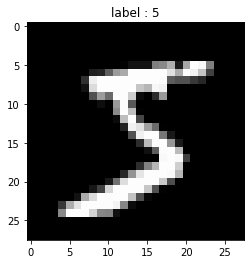

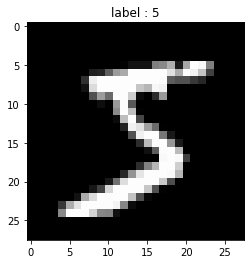

[[-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -1

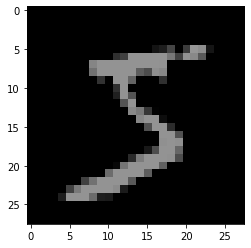

In [83]:
import numpy as np
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()


print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # float型に変換
image -= 105.35 # 意図的に負の小数値を作り出してみる
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()
print(image) # 値を確認

plt.imshow(image, 'gray', vmin = 0, vmax = 255)


X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

In [84]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [85]:
x_train, x_test, y_train, y_test= train_test_split(X_train, y_train, test_size=0.2)
print(x_train.shape) # (48000, 784)
print(x_test.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [96]:
import tensorflow as tf
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#255の整数値だが，0〜1の実数に変換する：
x_train, x_test = x_train / 255.0, x_test / 255.0

#簡単なモデルを定義
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

#学習
model.fit(x_train, y_train, epochs=5)

#評価
model.evaluate(x_test, y_test)

#予測
# y_pred = tf.argmax(model.predict(x_test), axis=-1).numpy()

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 86us/sample - loss: 0.2958 - accuracy: 0.9131
Epoch 2/5
60000/60000 [==============================] - 5s 91us/sample - loss: 0.1422 - accuracy: 0.9583
Epoch 3/5
60000/60000 [==============================] - 5s 91us/sample - loss: 0.1057 - accuracy: 0.9675
Epoch 4/5
60000/60000 [==============================] - 5s 90us/sample - loss: 0.0871 - accuracy: 0.9725
Epoch 5/5
60000/60000 [==============================] - 5s 91us/sample - loss: 0.0759 - accuracy: 0.9755


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


[0.0757194505580701, 0.9757]